In [1]:
ROOT_DIR = "/home/user/Documents/projects/Metaworld"
%env MUJOCO_GL=egl

import sys
sys.path.append(ROOT_DIR)

import os
import functools
import json
from tqdm import tqdm
import importlib
from dataclasses import dataclass

# scientific
import cv2
import numpy as np
import torch
import pytorch_lightning as pl

# gym
# from gym.spaces import Box
import mujoco
import metaworld
from metaworld import MT1

# plotting
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from lightglue import viz2d

# project imports
# from metaworld.envs.mujoco.sawyer_xyz.test_scripted_policies import ALL_ENVS, test_cases_latest_nonoise
# import reset_space
import utils.camera_utils_v2 as cu
import keyframes.env_utils as env_utils
import keyframes.env_renderer as env_renderer
import keyframes.mujoco_utils as mujoco_utils
import keyframes.keyframe_utils as keyframe_utils
import utils.predict_utils as keyframe_predict

import utils.slam_utils as slam_utils
import utils.depth_utils as depth_utils
import utils.match_utils as match_utils
import utils.transform_utils as transform_utils
import utils.inference_utils as inference_utils

import models.extern.mcc_model as mcc_model
import utils.mcc_misc_utils as mcc_misc_utils
import utils.mcc_data_utils as mcc_data_utils
import utils.predict_utils as predict_utils
import utils.vis_utils as vis_utils
import utils.plotly_utils as plotly_utils
import utils.torch_utils as torch_utils

from pytorch3d.io.obj_io import load_obj

import keyframes.estimators.grasp_pose_estimator as grasp_pose_estimator
import keyframes.estimators.push_pose_estimator as push_pose_estimator
import keyframes.policies.expert_policy_utils as expert_policy_utils
import keyframes.policies.pick_place_policy as pick_place_policy
import keyframes.seg_any as seg_any
import keyframes.mcc as mcc

DEVICE = "cuda"


import keyframes.finetune_lightglue.dataset as dataset
import utils.match_utils as match_utils
import utils.inference_utils as inference_utils
import utils.plotly_utils as plotly_utils
import utils.depth_utils as depth_utils
import keyframes.finetune_lightglue.pl_modules as pl_modules


env: MUJOCO_GL=egl


In [2]:
importlib.reload(dataset)
importlib.reload(match_utils)

<module 'utils.match_utils' from '/home/user/Documents/projects/Metaworld/utils/match_utils.py'>

In [3]:
EXCLUDED_ENV_IDS = [1,22,31,41,42]
NUM_ENVS = 50

env_ids = []
for i in range(NUM_ENVS):
    if i not in EXCLUDED_ENV_IDS:
        env_ids.append(i)
print(env_ids)

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 47, 48, 49]


In [4]:
# model cktps
model_ckpts_dir = "/home/user/Documents/model_ckpts/"
fts_match_ckpt_path = f"{model_ckpts_dir}/lightglue_epoch=34-step=3885.ckpt"
seg_any_ckpt_path = f"{model_ckpts_dir}/sam_vit_h_4b8939.pth"
mcc_ckpt_path = f"{model_ckpts_dir}/co3dv2_all_categories.pth"

# load models

# load feature extractor
model_fts_extract = slam_utils.get_super_glue_extractor(device=DEVICE)

# load feature matching model
config = inference_utils.load_config("feature_matching", "01", ROOT_DIR=ROOT_DIR)
# model_fts_match = pl_modules.PLModel()  # config["model_args"], config["optimizer_args"]
model_fts_match = pl_modules.PLModel.load_from_checkpoint(fts_match_ckpt_path)
model_fts_match.to(DEVICE)
model_fts_match.eval()

img_height, img_width = 360, 480
img_shape = (img_height, img_width)

In [5]:
# reference keyframes env

# param
env_index = 1


# generate env and renderer
env, expert_policy, renderer = env_utils.generate_env_and_renderer(env_index, height=img_height, width=img_width, camera_name="keyframes")
T_world2pixel = cu.get_camera_transform_matrix(env, "keyframes", img_height, img_width)
T_pixel2world = np.linalg.inv(T_world2pixel)


# generate keyframes
keyframe_data_a = keyframe_utils.generate_keyframes(env, renderer)

img_ref_0 = keyframe_data_a["img"][0]
img_ref_1 = keyframe_data_a["img"][1]
depth_ref_0 = keyframe_data_a["depth"][0]
depth_ref_1 = keyframe_data_a["depth"][1]

# generate keyframe of current env
img_cur, depth_cur = keyframe_utils.generate_cur_keyframe(env, renderer)
xyz = depth_utils.pixel_coords_to_world_coords(
    T_pixel2world, 
    depth_cur,
)[:,:3]

# viz2d.plot_images([img_ref_0, img_ref_1, img_cur])

In [6]:
importlib.reload(match_utils)

<module 'utils.match_utils' from '/home/user/Documents/projects/Metaworld/utils/match_utils.py'>

In [7]:
def generate_keyframe_data(env_index):
    # generate env and renderer
    env_1, expert_policy, renderer_1 = env_utils.generate_env_and_renderer(env_index, height=img_height, width=img_width, camera_name="keyframes")
    env_2, expert_policy, renderer_2 = env_utils.generate_env_and_renderer(env_index, height=img_height, width=img_width, camera_name="keyframes")

    # generate keyframe data
    keyframe_data_a = keyframe_utils.generate_keyframes(env_1, renderer_1)
    keyframe_data_b = keyframe_utils.generate_keyframes(env_2, renderer_2)

    return keyframe_data_a, keyframe_data_b, env_1, env_2

In [8]:
def match_keyframe_data(keyframe_data_a, keyframe_data_b, T_pixel2world, model_fts_extract, table_offset_z=0.0, max_keypoints=100, eps=0.01):
    img_a_0 = keyframe_data_a["img"][0]
    img_a_1 = keyframe_data_a["img"][1]
    depth_a_0 = keyframe_data_a["depth"][0]
    depth_a_1 = keyframe_data_a["depth"][1]
    seg_a_0 = keyframe_data_a["seg"][0]
    seg_a_1 = keyframe_data_a["seg"][1]
    geom_xpos_a_0 = keyframe_data_a["geom_xpos"][0]
    geom_xpos_a_1 = keyframe_data_a["geom_xpos"][1]
    geom_xmat_a_0 = keyframe_data_a["geom_xmat"][0]
    geom_xmat_a_1 = keyframe_data_a["geom_xmat"][1]

    img_b_0 = keyframe_data_b["img"][0]
    img_b_1 = keyframe_data_b["img"][1]
    depth_b_0 = keyframe_data_b["depth"][0]
    depth_b_1 = keyframe_data_b["depth"][1]
    seg_b_0 = keyframe_data_b["seg"][0]
    seg_b_1 = keyframe_data_b["seg"][1]
    geom_xpos_b_0 = keyframe_data_b["geom_xpos"][0]
    geom_xpos_b_1 = keyframe_data_b["geom_xpos"][1]
    geom_xmat_b_0 = keyframe_data_b["geom_xmat"][0]
    geom_xmat_b_1 = keyframe_data_b["geom_xmat"][1]

    kpts_a_0, desc_a_0, _, wpos_kpts_a_0 = inference_utils.compute_img_features(
        model_fts_extract, img_a_0, depth_a_0, T_pixel2world, table_offset_z=table_offset_z
    )
    kpts_a_1, desc_a_1, _, wpos_kpts_a_1 = inference_utils.compute_img_features(
        model_fts_extract, img_a_1, depth_a_1, T_pixel2world, table_offset_z=table_offset_z
    )
    kpts_b_0, desc_b_0, _, wpos_kpts_b_0 = inference_utils.compute_img_features(
        model_fts_extract, img_b_0, depth_b_0, T_pixel2world, table_offset_z=table_offset_z
    )   

    match_data_a0a1 = match_utils.match_features(
        T_pixel2world,
        img_a_0, img_a_1,
        depth_a_0, depth_a_1,
        seg_a_0[:,:,0], seg_a_1[:,:,0],
        geom_xpos_a_0, geom_xpos_a_1,
        geom_xmat_a_0, geom_xmat_a_1,
        kpts_a_0, kpts_a_1,
        desc_a_0, desc_a_1,
        ngeom=geom_xpos_a_0.shape[0],
        max_keypoints=max_keypoints,
        eps=eps
    )
    match_data_a0b0 = match_utils.match_features(
        T_pixel2world,
        img_a_0, img_b_0,
        depth_a_0, depth_b_0,
        seg_a_0[:,:,0], seg_b_0[:,:,0],
        geom_xpos_a_0, geom_xpos_b_0,
        geom_xmat_a_0, geom_xmat_b_0,
        kpts_a_0, kpts_b_0,
        desc_a_0, desc_b_0,
        ngeom=geom_xpos_a_0.shape[0],
        max_keypoints=max_keypoints,
        eps=eps
    )
    return match_data_a0a1, match_data_a0b0

In [9]:
importlib.reload(match_utils)

<module 'utils.match_utils' from '/home/user/Documents/projects/Metaworld/utils/match_utils.py'>

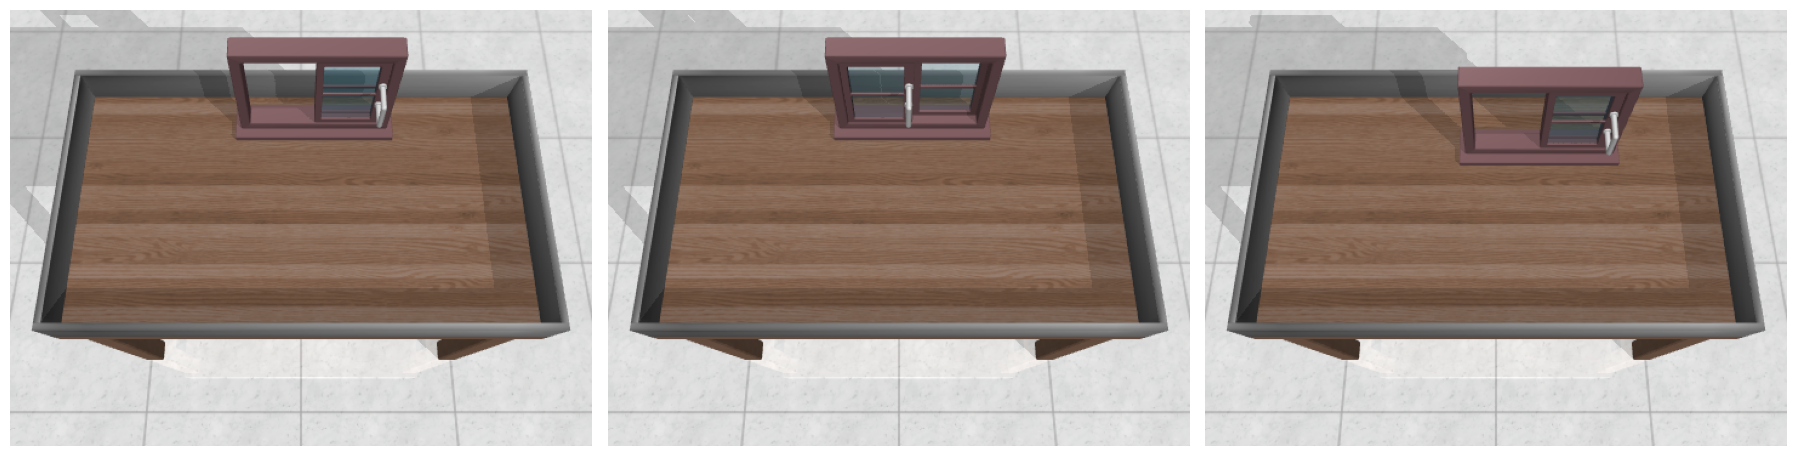

In [11]:
env_index = 49
keyframe_data_a, keyframe_data_b, env_a, env_b = generate_keyframe_data(env_index)
match_data_a0a1, match_data_a0b0 = match_keyframe_data(keyframe_data_a, keyframe_data_b, T_pixel2world, model_fts_extract, table_offset_z=0.05)
viz2d.plot_images([keyframe_data_a["img"][0], keyframe_data_a["img"][1], keyframe_data_b["img"][0]])

In [19]:
env_a.obj_init_pos

array([0.03812186, 0.06057668, 0.00798722])

In [12]:
env.model.body("basketball").id

34

In [12]:
env.data.xpos[env.model.body("bsktball").id]

array([ 0.40119035, -2.15736849, 75.54937228])

In [28]:
env.data.xpos[env.model.body("basketball").id]

array([ 0.36816139,  2.00545852, -0.88312784])

In [23]:
env.data.xpos.shape

(39, 3)

In [26]:
env.model.body_pos.shape

(39, 3)

In [24]:
env.data.geom_xpos.shape

(56, 3)

In [13]:
env_a.go_to_step(0)
mujoco.mj_kinematics(env_a.model, env_a.data)
print(env_a.obj_init_pos - env_a.data.xpos[env.model.body("basketball").id])
xpos_1 = env_a.data.xpos.copy()
env_a.go_to_step(1)
mujoco.mj_kinematics(env_a.model, env_a.data)
xpos_2 = env_a.data.xpos.copy()
print(env_a.obj_init_pos - env_a.data.xpos[env.model.body("basketball").id])
print(env_a._target_pos - env_a.data.xpos[env.model.body("basketball").id])


[0. 0. 0.]
[-0.30587007 -0.91407183 -0.24201278]
[0. 0. 0.]


In [42]:
diff = xpos_1 - xpos_2
diff[np.linalg.norm(diff, axis=1) > 0.0001]

array([[ 0.09958002, -0.77427326, -0.24201278],
       [ 0.09958002, -0.77427326, -0.24201278]])

array([-0.25498059, -1.93970226,  0.89111506])

In [14]:
env_a._target_pos - env.data.xpos[34]

array([-0.35456061, -1.16542901,  1.13312784])

In [19]:
env_a.obj_init_pos - env.data.xpos[34]

array([-0.11653599,  1.00758076,  0.89111505])

In [16]:
env_a._target_pos

array([0.18111899, 0.78116295, 0.25      ])

In [19]:
env_a._basket_pos

array([0.18111899, 0.83116295, 0.        ])

In [17]:
env_a.data.qpos[9:12]

array([0.18111899, 0.78116295, 0.25      ])

In [12]:
env_a.data.joint("")

KeyError: "Invalid name ''. Valid names: ['l_close', 'r_close', 'right_j0', 'right_j1', 'right_j2', 'right_j3', 'right_j4', 'right_j5', 'right_j6']"

In [10]:
for n in ['l_close', 'r_close', 'right_j0', 'right_j1', 'right_j2', 'right_j3', 'right_j4', 'right_j5', 'right_j6']:
    print(env_a.data.joint(n).id)
env_a.data.joint("right_j6").id

8
7
0
1
2
3
4
5
6


6

In [20]:
root, node_map = mujoco_utils.build_mj_tree(env_a.model)
mujoco_utils.visualize_mj_tree(root)

print(env_a.obj_init_pos, env_a._target_pos, env_a._basket_pos)
print(env_a.model.body("basketball").id, env_a.model.body("bsktball").id)

to = env_a._target_pos
env_a._set_obj_xyz(to)
mujoco.mj_forward(env_a.model, env_a.data)
print(to, env.data.xpos[3], env.data.xpos[4], env_a.data.qpos.flat[9:12])

0 world
| 1 tablelink
| 2 RetainingWall
| 3 base
| | 4 controller_box
| | 5 pedestal_feet
| | 6 torso
| | 7 pedestal
| | 8 right_arm_base_link
| | | 9 right_l0
| | | | 10 head
| | | | | 11 screen
| | | | | 12 head_camera
| | | | 13 right_torso_itb
| | | | 14 right_l1
| | | | | 15 right_l2
| | | | | | 16 right_l3
| | | | | | | 17 right_l4
| | | | | | | | 18 right_arm_itb
| | | | | | | | 19 right_l5
| | | | | | | | | 20 right_hand_camera
| | | | | | | | | 21 right_wrist
| | | | | | | | | 22 right_l6
| | | | | | | | | | 23 right_hand
| | | | | | | | | | | 24 hand
| | | | | | | | | | | | 25 rightclaw
| | | | | | | | | | | | | 26 rightpad
| | | | | | | | | | | | 27 leftclaw
| | | | | | | | | | | | | 28 leftpad
| | | | | | | | 29 right_l4_2
| | | | | | 30 right_l2_2
| | | | | 31 right_l1_2
| 32 mocap
| 33 bsktball
| | 34 basketball
| 35 basket_goal
| | 36 basketballhoop
| | | 37 backboardlink
| | | | 38 hooplink
[-0.06487914 -0.03101041  0.00798722] [0.14102233 0.80131447 0.25      ] [0.1410

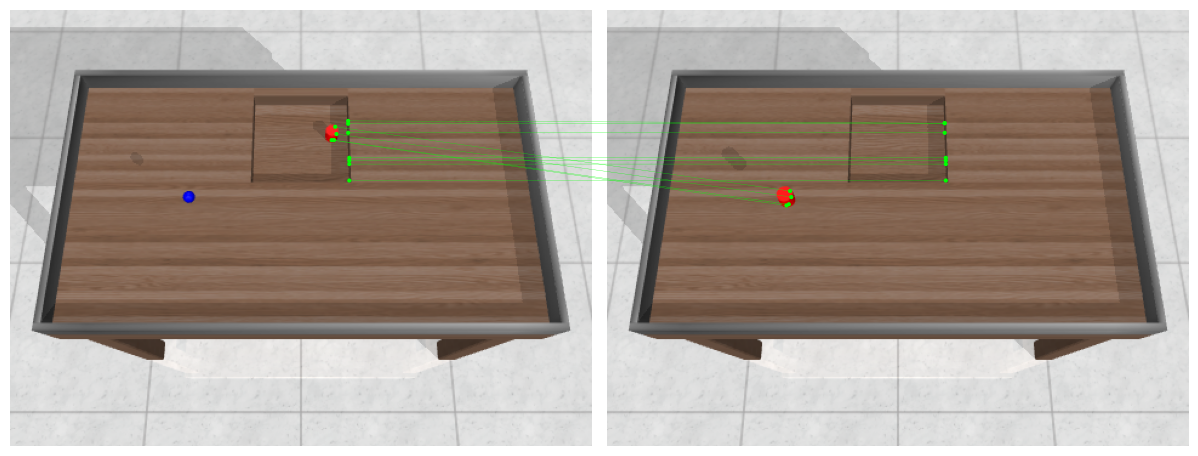

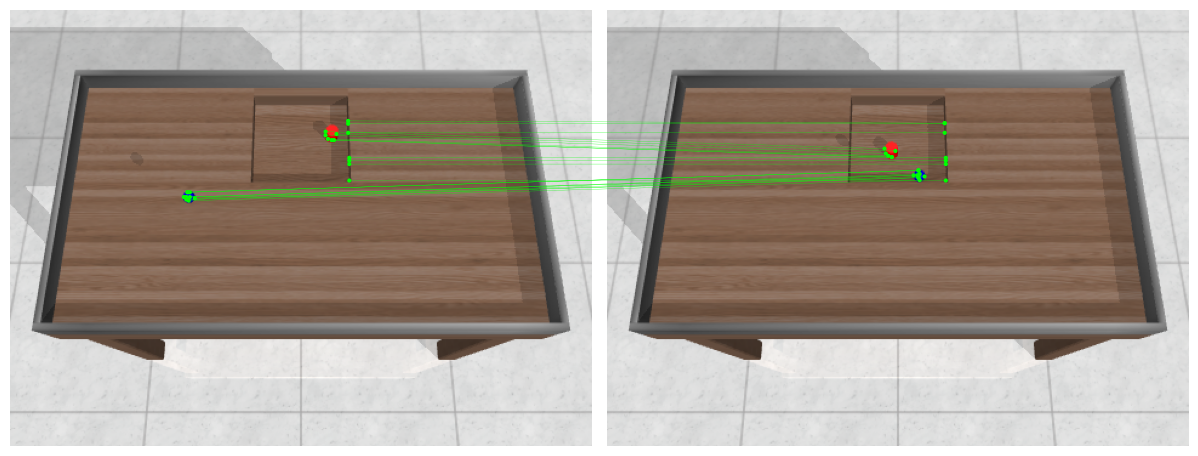

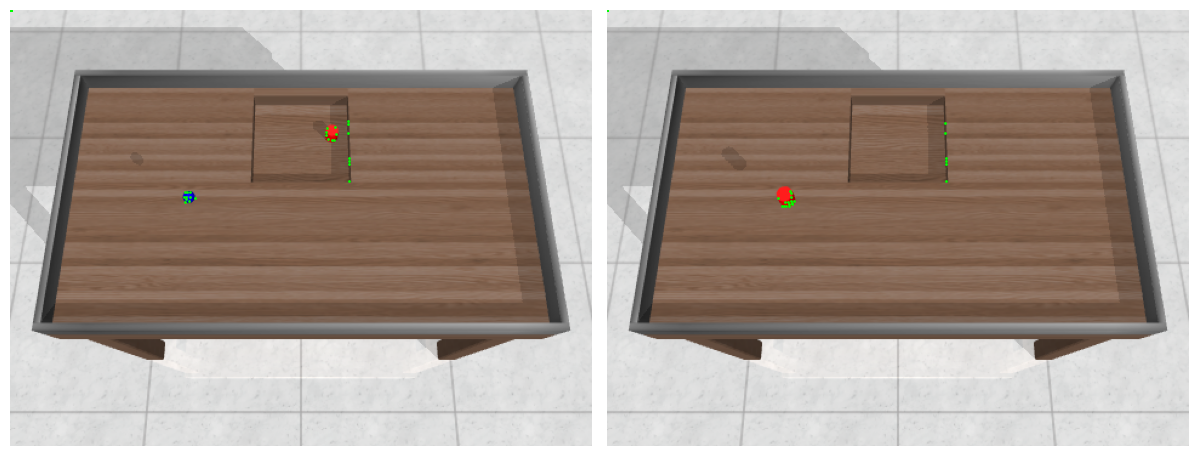

In [73]:
inference_utils.visualize_keypoint_matches_0(
    keyframe_data_a["img"][0], 
    keyframe_data_a["img"][1], 
    match_data_a0a1["kpts_0_adjusted"], match_data_a0a1["kpts_1_adjusted"], 
    match_data_a0a1["matches_0"]
)
inference_utils.visualize_keypoint_matches_0(
    keyframe_data_a["img"][0], 
    keyframe_data_b["img"][0], 
    match_data_a0b0["kpts_0_adjusted"], match_data_a0b0["kpts_1_adjusted"], 
    match_data_a0b0["matches_0"]
)
viz2d.plot_images([keyframe_data_a["img"][0], keyframe_data_a["img"][1]])
viz2d.plot_keypoints([match_data_a0a1["kpts_0_adjusted"], match_data_a0a1["kpts_1_adjusted"]])

In [74]:
plotly_utils.plot_scatter([match_data_a0a1["world_coords_0"]])

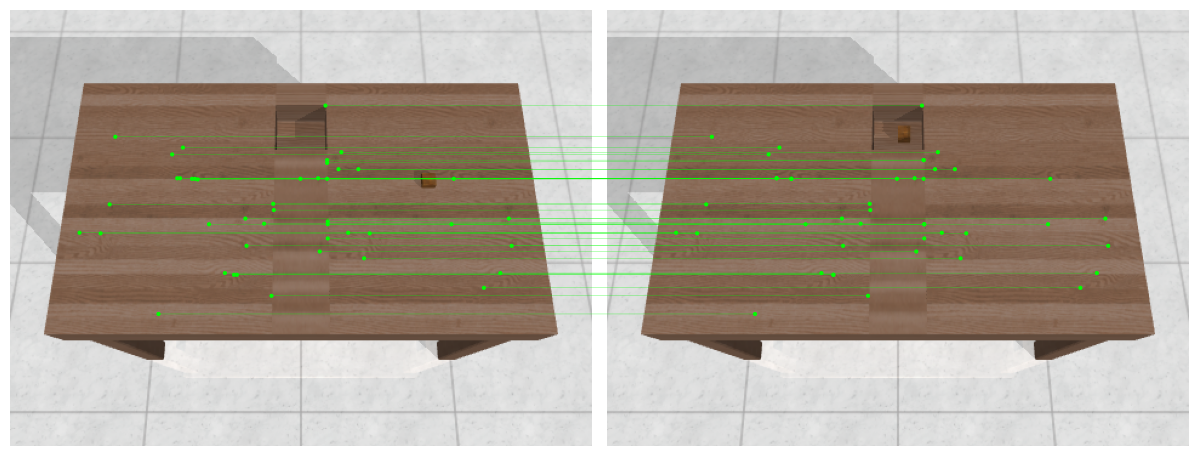

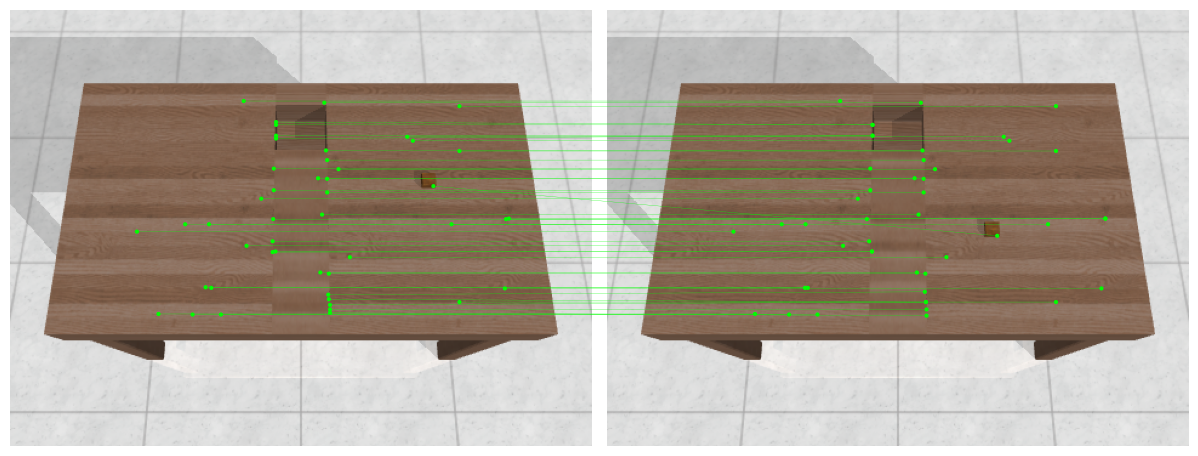

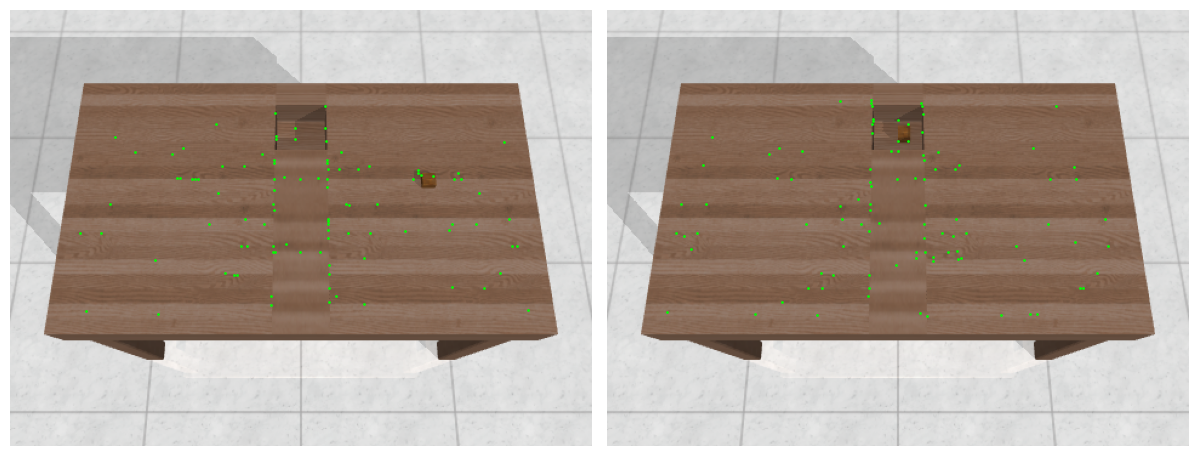

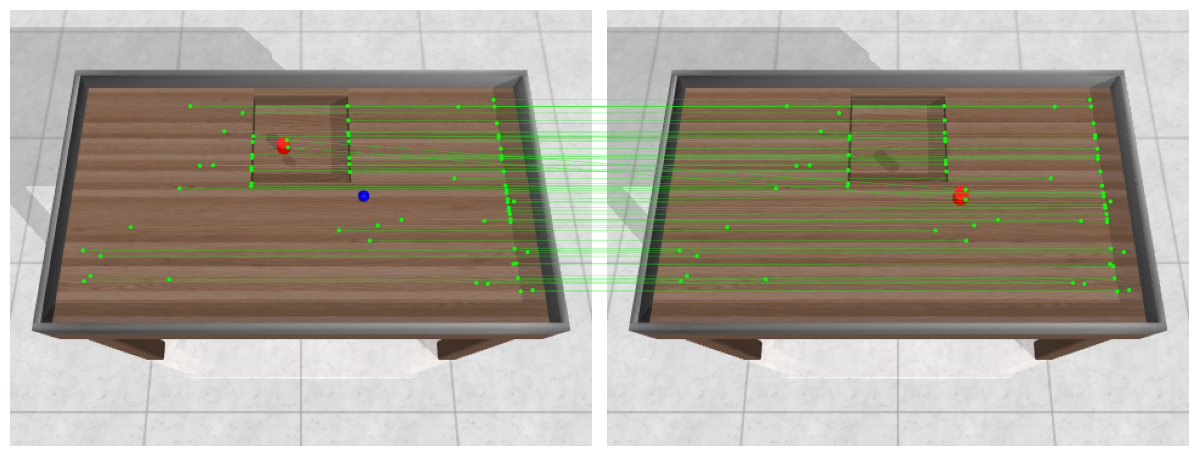

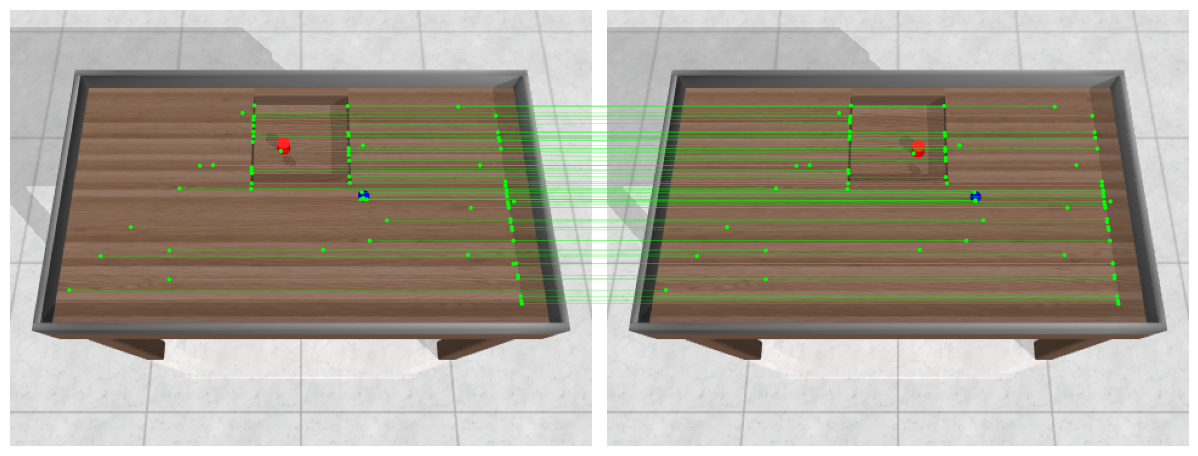

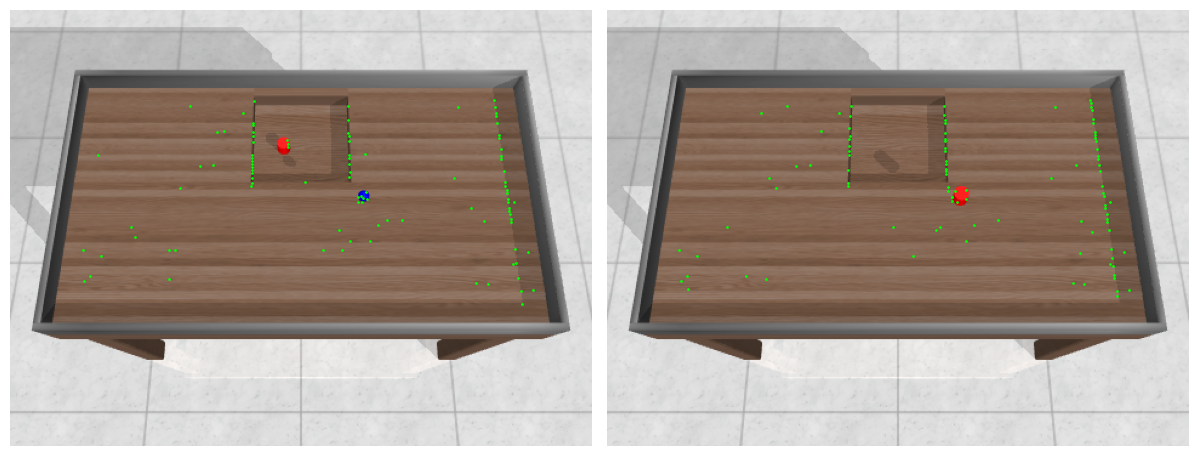

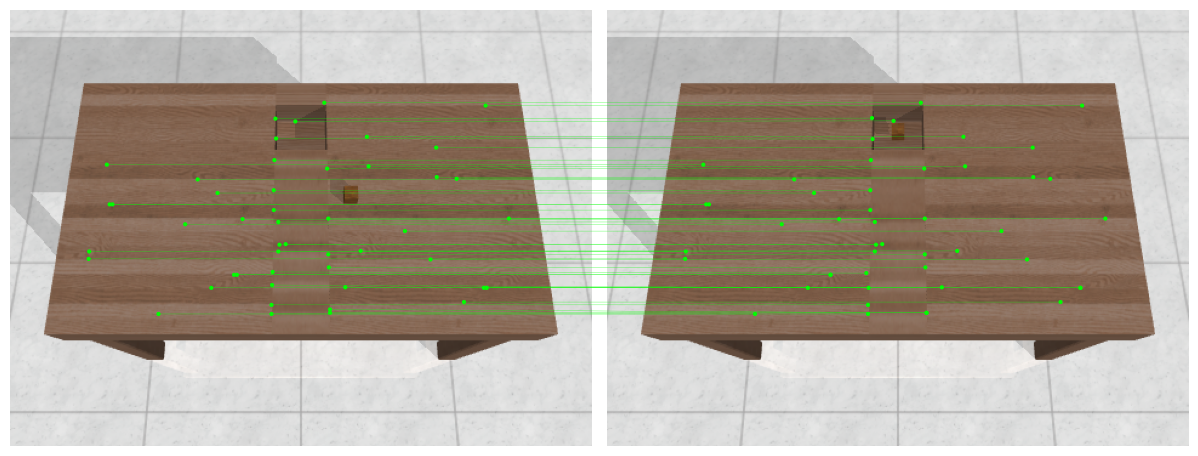

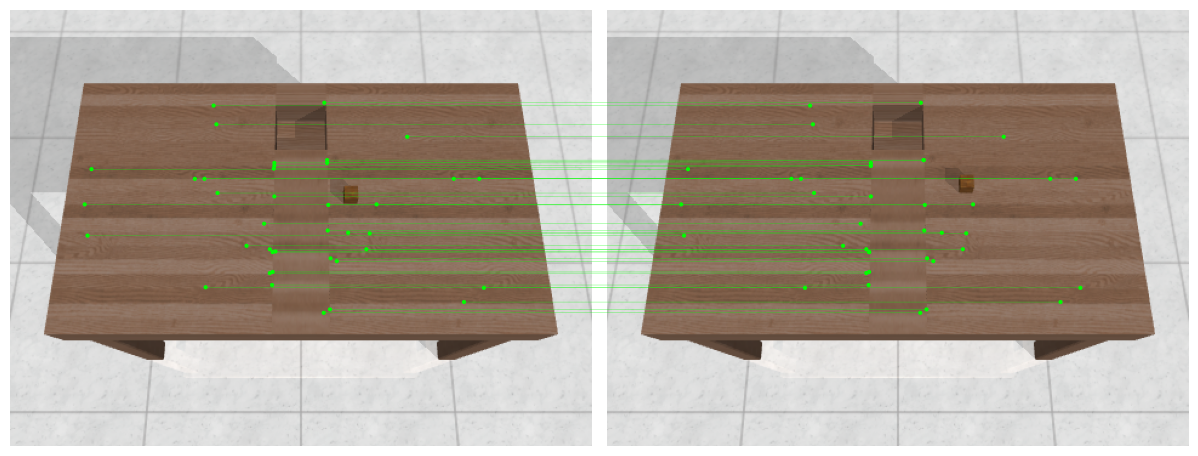

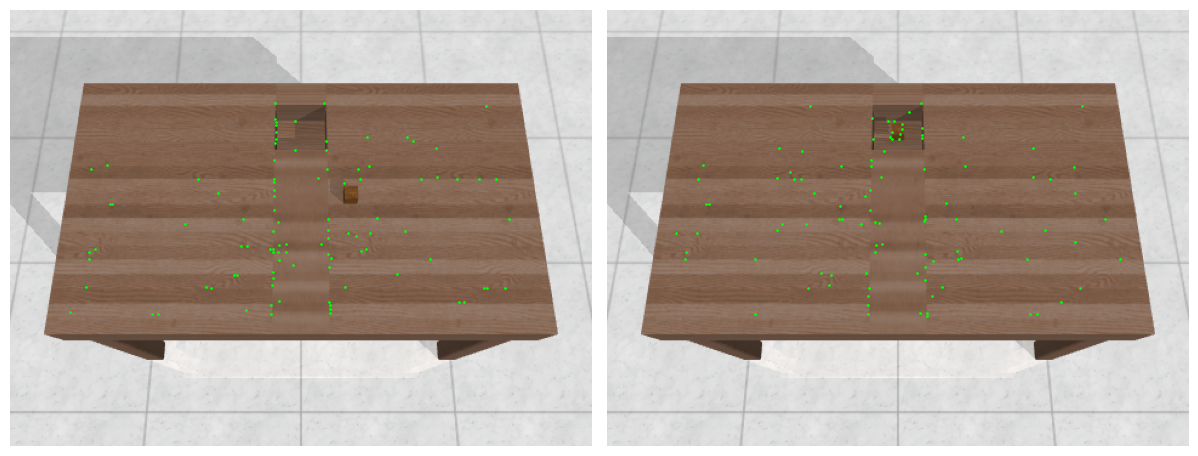

In [44]:
for i in [17, 30, 46]:
    env_index = i
    try:
        keyframe_data_a, keyframe_data_b = generate_keyframe_data(env_index)
        match_data_a0a1, match_data_a0b0 = match_keyframe_data(keyframe_data_a, keyframe_data_b, T_pixel2world, model_fts_extract)
        inference_utils.visualize_keypoint_matches_0(
            keyframe_data_a["img"][0], 
            keyframe_data_a["img"][1], 
            match_data_a0a1["kpts_0_adjusted"], match_data_a0a1["kpts_1_adjusted"], 
            match_data_a0a1["matches_0"]
        )
        inference_utils.visualize_keypoint_matches_0(
            keyframe_data_a["img"][0], 
            keyframe_data_b["img"][0], 
            match_data_a0b0["kpts_0_adjusted"], match_data_a0b0["kpts_1_adjusted"], 
            match_data_a0b0["matches_0"]
        )
        viz2d.plot_images([keyframe_data_a["img"][0], keyframe_data_a["img"][1]])
        viz2d.plot_keypoints([match_data_a0a1["kpts_0_adjusted"], match_data_a0a1["kpts_1_adjusted"]])
    except Exception as e:
        print(f"Error: {str(e)}", env_index)


In [ ]:
"""
(-0.6, 0.26, 0.05)
(-0.08, 0.7/8, 0.05)
"""

In [13]:
importlib.reload(match_utils)
importlib.reload(dataset)

<module 'keyframes.finetune_lightglue.dataset' from '/home/user/Documents/projects/Metaworld/keyframes/finetune_lightglue/dataset.py'>

In [15]:
data = dataset.MetaworldFeatureMatchingDataset(
    data_folder="/media/user/ssd2t/datasets2/metaworld_keyframes/all_envs",
    max_keypoints=50,
    env_ids=env_ids,
    eps=0.01,
    dev=False
)

In [17]:
kpts_0, kpts_1, dscpt_0, dscpt_1, matches_0, matches_1, assignment_mtr = data[0]

In [21]:
print(kpts_0.shape, kpts_1.shape, dscpt_0.shape, dscpt_1.shape, matches_0.shape, matches_1.shape, assignment_mtr.shape)
print(kpts_0.device, kpts_1.device, dscpt_0.device, dscpt_1.device, matches_0.device, matches_1.device, assignment_mtr.device)

torch.Size([50, 2]) torch.Size([50, 2]) torch.Size([50, 256]) torch.Size([50, 256]) torch.Size([50]) torch.Size([50]) torch.Size([50, 50])
cpu cpu cpu cpu cpu cpu cpu


In [14]:
data = dataset.MetaworldFeatureMatchingDataset(
    data_folder="/media/user/ssd2t/datasets2/metaworld_keyframes/all_envs",
    max_keypoints=50,
    env_ids=env_ids,
    eps=0.01,
    dev=True
)

In [13]:
s = np.random.randint(0, len(data))
img_0, img_1, depth_0, depth_1, seg_0, seg_1, match_data = data[s]
kpts_0 = match_data["keypoints_0"]
kpts_1 = match_data["keypoints_1"]
dscpt_0 = match_data["descriptors_0"]
dscpt_1 = match_data["descriptors_1"]
matches_0 = match_data["matches_0"]
matches_1 = match_data["matches_1"]
assignment_mtr = match_data["assignment_mtr"]
world_coords_0 = match_data["world_coords_0"]
world_coords_1 = match_data["world_coords_1"]
# img_0, img_1, depth_0, depth_1, seg_0, seg_1, match_data, kpts_0, kpts_1, dscpt_0, dscpt_1, matches_0, matches_1, assignment_mtr = data[s]

In [9]:
kpts_0.shape

torch.Size([50, 2])

In [10]:
kpts_1.shape

torch.Size([50, 2])

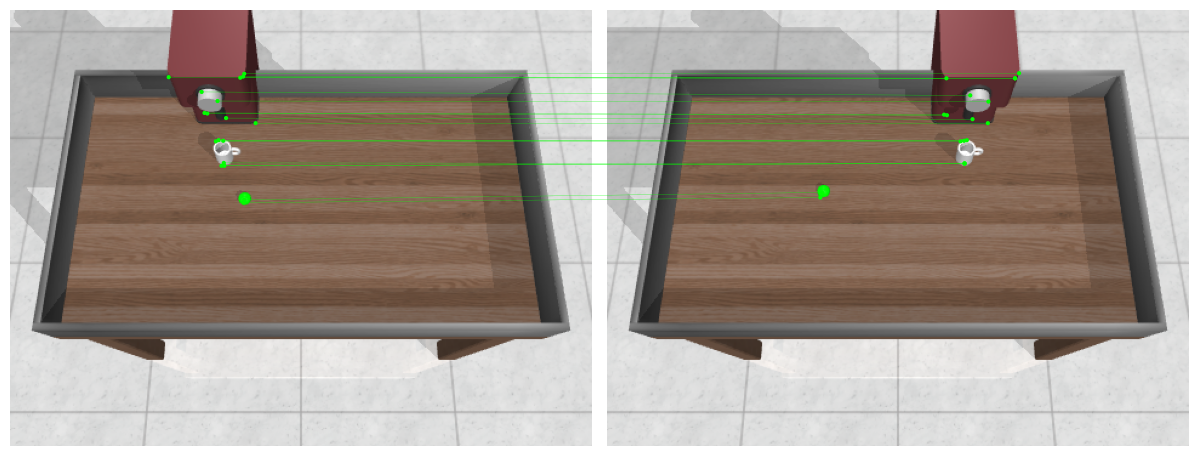

In [14]:
inference_utils.visualize_keypoint_matches_0(img_0, img_1, kpts_0, kpts_1, matches_0)

In [31]:
img_0.shape

torch.Size([360, 480, 3])

In [32]:
img_1.shape

torch.Size([360, 480, 3])

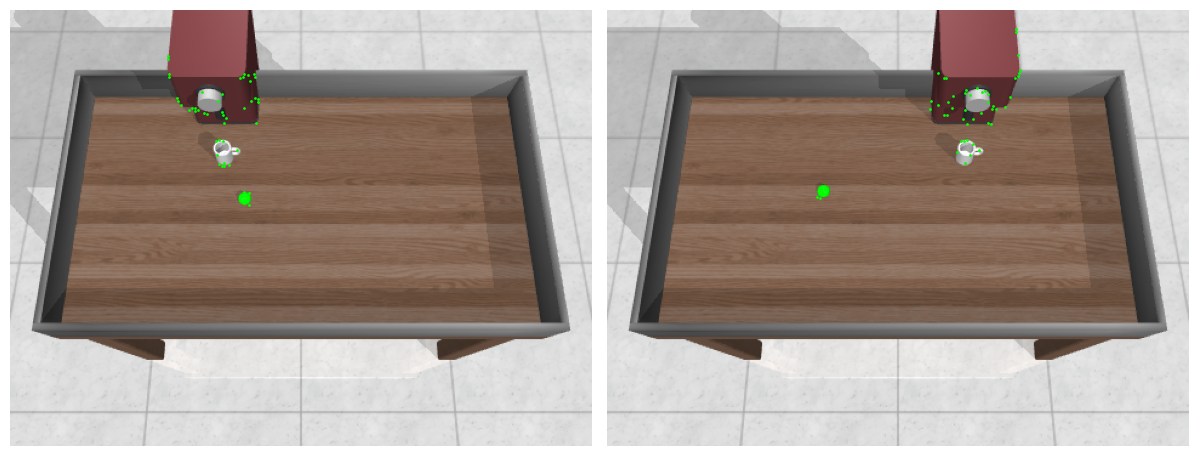

In [15]:
viz2d.plot_images([img_0.numpy(), img_1.numpy()])
viz2d.plot_keypoints([kpts_0, kpts_1])

In [18]:
wpos_kpts_0 = depth_utils.pixel_coords_to_world_coords(T_pixel2world, depth_0.numpy(), kpts_0.numpy())

In [45]:
plotly_utils.plot_scatter([world_coords_0])

In [ ]:
match_utils.visualize_matches_with_imgs(img_0.numpy(), img_1.numpy(), match_data)

In [31]:
seg_0.shape

torch.Size([360, 480, 2])